In [22]:
import networkx as nx
import geopandas as gpd
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.stats import entropy

import pandas as pd
from pandas import DataFrame
from pandas import read_excel, merge

%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import pandana, matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from pandana.loaders import osm

from shapely.geometry import Point

import sys
sys.path.append("C:/Users/a/Anaconda/envs/ox/lib/site-packages/")
import pandana as pdna
from pandana.loaders import osm

import sys
sys.path.append("C:/Users/a/Anaconda/Lib/site-packages/")
import openpyxl
import xlsxwriter
import momepy

import osmnx as ox
ox.config(log_file=True, log_console=True, use_cache=True)
ox.__version__

'0.15.1'

In [8]:
tags = '["highway"~"primary|secondary|tertiary|unclassified|residential|pedestrian|steps|path|service"]'
cities_3 = ["Valencia", "Barcelona", "Paris"]
points_3 = [(39.466667, -0.375),(41.390205, 2.154007), (48.856613, 2.352222)]
distance = 300

# 1. Stats

##### Idealized network 

#### Real network

In [20]:
for i in range(0, len(points_3)):
    G = ox.graph_from_point(points_3[i], dist=distance, network_type='none', custom_filter = tags)
    basic_stats = ox.basic_stats(G,  area=None, clean_intersects=True, tolerance=15, circuity_dist='gc')
    df_stats_basic = pd.DataFrame.from_dict(basic_stats)
    ##### Save output to Excel
    writer = pd.ExcelWriter('G:/Thesis/ISU/basic'+'_'+ cities_3[i]+ '.xlsx', engine='xlsxwriter')
    df_stats_basic.to_excel(writer, sheet_name=cities_3[i], index_label= 1)
    writer.save()
    
    extended_stats = ox.extended_stats(G, connectivity=True, anc=False, ecc=False, bc=True, cc=False)
    df_stats_extended = pd.DataFrame.from_dict(extended_stats)
    ##### Save output to Excel
    writer = pd.ExcelWriter('G:/Thesis/ISU/extended'+'_'+ cities_3[i]+ '.xlsx', engine='xlsxwriter')
    df_stats_extended.to_excel(writer, sheet_name=cities_3[i], index_label= 1)
    writer.save()

# 2. Topology

### 2.1 Degree distribution

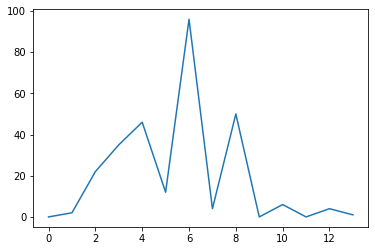

In [27]:
#Barcelona

G = ox.graph_from_point(points_3[1], dist=distance, network_type='none', custom_filter = tags)
k = dict(G.degree())
degree_distribution = {n:list(k.values()).count(n) for n in range(max(k.values()) + 1)}

lists = sorted(degree_distribution.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.show()

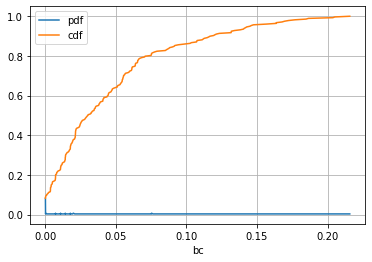

,bc,frequency,pdf,cdf
0,0.000000,23,0.082734,0.082734
1,0.000092,1,0.003597,0.086331
2,0.000209,2,0.007194,0.093525
3,0.000837,1,0.003597,0.097122
4,0.000916,1,0.003597,0.100719
...,...,...,...,...
244,0.184756,1,0.003597,0.985612
245,0.186522,1,0.003597,0.989209
246,0.203801,1,0.003597,0.992806
247,0.205135,1,0.003597,0.996403


In [29]:
#Barcelona
###### node betweenness centrality(BC)
G_DiGraph = nx.DiGraph(G)
node_betweenness_centrality = nx.betweenness_centrality(G_DiGraph, weight='length',normalized=True)

df = pd.DataFrame(dict(
    node_betweenness_centrality = nx.betweenness_centrality(G_DiGraph, weight='length',normalized=True)
))

df_bc = pd.DataFrame(data=pd.Series(node_betweenness_centrality).sort_values(), columns=['bc'])

# ===========================================================
# Frequency
stats_df = df_bc \
.groupby('bc') \
['bc'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'bc': 'frequency'})

# # PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# # CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()

stats_df = stats_df.reset_index()

stats_df.plot(x = 'bc', y = ['pdf', 'cdf'], grid = True)
# stats_df.plot.bar(x = 'bc', y = ['pdf', 'cdf'], grid = True)
plt.show()

stats_df

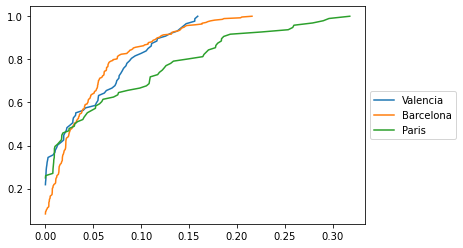

In [26]:
#3 cities
##### Loop through all cities
fig = plt.figure()
ax = fig.add_subplot(111)

dict1 = {} #要把所有城市的DataFrame存成dictionary才能plot
dict2 = {}

for i in range(0, len(points_3)):
    G = ox.graph_from_point(points_3[i], dist=distance, network_type='none', custom_filter = tags)
    G_DiGraph = nx.DiGraph(G)
    node_betweenness_centrality = nx.betweenness_centrality(G_DiGraph, weight='length',normalized=True)
    df_bc = pd.DataFrame(data=pd.Series(node_betweenness_centrality).sort_values(), columns=['bc'])
    
    stats_df = df_bc \
    .groupby('bc') \
    ['bc'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'bc': 'frequency'})
    
    #### PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    ##### CDF
    stats_df['cdf'+'_'+cities_3[i]] = stats_df['pdf'].cumsum()
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    
    stats_df1 = stats_df.reset_index()
    stats_df2 = stats_df['cdf'+'_'+cities_3[i]]
    
    #####==============================
    dict1[i] = pd.DataFrame()
    dict1[i] = stats_df1
    
#     df1=df1.append(stats_df1,ignore_index=True) ####Vertically adding cases #https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop
#     df2=df2.append(stats_df2,ignore_index=True) ####Vertical adding rows
#     df3[ cities[i] + '_' + str(i)] = stats_df2 #####Horizonally adding columns
    
#     ar1.append(stats_df2)
    #####==============================
    ax.plot(dict1[i]['bc'],dict1[i]['cdf'+'_'+cities_3[i]], label = cities_3[i])
    ax.legend(loc='upper left', frameon=False)

plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 2.2 clustering coefficient

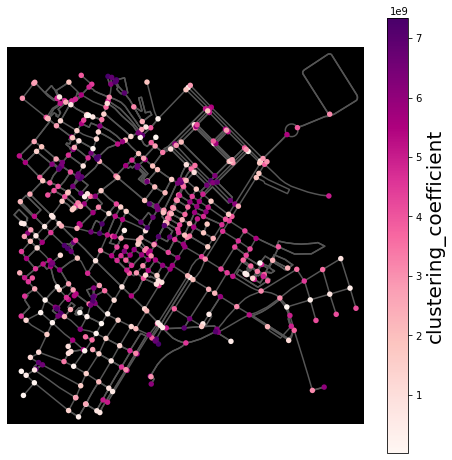

In [31]:
#Paris: 48.856613, 2.352222
#Barcelona: 41.383333, 2.183333

distance_clustering = 500
G = ox.graph_from_point((41.383333, 2.183333), dist=distance_clustering, network_type='none', custom_filter = tags)
extended_stats = ox.extended_stats(G, connectivity=True, anc=False, ecc=False, bc=True, cc=True)

df_clustering_coefficient = pd.DataFrame(data=pd.Series(extended_stats['clustering_coefficient']).sort_values(), columns=['clustering_coefficient'])
df_clustering_coefficient['colors'] = ox.plot.get_colors(n=len(df_clustering_coefficient), cmap='RdPu', start=0.002)
df_clustering_coefficient = df_clustering_coefficient.reindex(G.nodes())
nc = df_clustering_coefficient['colors'].tolist()

fig, ax = ox.plot_graph(G, bgcolor='black', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                                 edge_color='#555555', edge_linewidth=1.5, edge_alpha=1, show=False, close=False)

# # =====Plot legend with　plt ===https://stackoverflow.com/questions/61880977/how-to-create-a-color-bar-in-an-osmnx-plot==========================
cmap3 = 'RdPu'
norm3= plt.Normalize(vmin=min(extended_stats['clustering_coefficient']),vmax=max(extended_stats['clustering_coefficient']))
cb3 = fig.colorbar(cm.ScalarMappable(norm=norm3, cmap=cmap3), ax=ax, orientation='vertical')
cb3.set_label('clustering_coefficient', fontsize = 20)
cb3.ax.tick_params(labelsize=10)
plt.show()

# 3. Visualization

### 3.1 Color nodes by attributes (betweenness centrality)

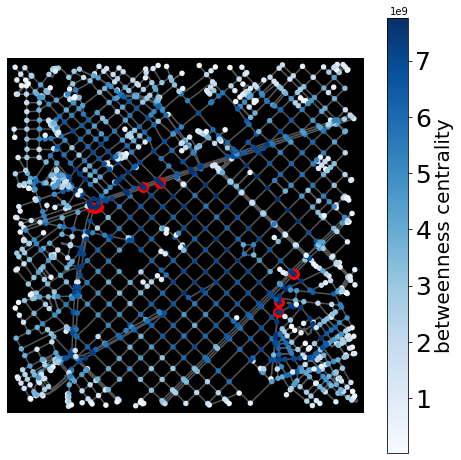

In [48]:
#Valencia: 39.466667, -0.375
#Barcelona: 41.383333, 2.183333
# 41.390205, 2.154007
#Paris: 48.856613, 2.352222
#Vienna:48.2, 16.366667

#=====Create graph=========
G = ox.graph_from_point((41.390205, 2.154007), dist=1500, network_type='none', custom_filter = tags)

#=====Calculate node betweenness centrality(BC)
G_DiGraph = nx.DiGraph(G)
node_betweenness_centrality = nx.betweenness_centrality(G_DiGraph, weight='length',normalized=True)
df = pd.DataFrame(dict(
    node_betweenness_centrality = nx.betweenness_centrality(G_DiGraph, weight='length',normalized=True)
))

df_bc = pd.DataFrame(data=pd.Series(node_betweenness_centrality).sort_values(), columns=['bc'])

#=====Match BC with color 
df_bc['colors'] = ox.plot.get_colors(n=len(df_bc), cmap='Blues', start=0.002)
df_bc = df_bc.reindex(G.nodes())
nc = df_bc['colors'].tolist()

#=====Color nodes by BC
fig, ax = ox.plot_graph(G, bgcolor='black', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                         edge_color='#555555', edge_linewidth=1.5, edge_alpha=1, show=False, close=False)

#=====Plot the highest betweenness centrality
smallest_bc = df_bc.loc[df_bc['bc']==0] #select the node with BC ==0
smallest_bc

bc_id = sorted(node_betweenness_centrality, key = node_betweenness_centrality.get, reverse = True)
h_bc = list(bc_id[:10])  ##Select 10 nodes with highest BC
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
select_node_h_bc  = gdf_nodes.loc[gdf_nodes['osmid'].isin(h_bc)]  

gdf_intersections2 = gpd.GeoDataFrame(select_node_h_bc, columns=['geometry'], crs=G.graph['crs'])  
bc_lon = gdf_intersections2['geometry'].map(lambda pt: pt.coords[0][0])
bc_lat = gdf_intersections2['geometry'].map(lambda pt: pt.coords[0][1])
bc_lon_list = list(bc_lon)
bc_lat_list = list(bc_lat)
bc_coord = (bc_lat, bc_lon)   #Return: values

ax.scatter(bc_lon, bc_lat, c = 'red', s = 100, alpha=1)

# =====Plot legend with　plt
cmap3 = 'Blues'
norm3= plt.Normalize(vmin=min(node_betweenness_centrality),vmax=max(node_betweenness_centrality))
cb3 = fig.colorbar(cm.ScalarMappable(norm=norm3, cmap=cmap3), ax=ax, orientation='vertical')

cb3.set_label('betweenness centrality', fontsize = 20)
cb3.ax.tick_params(labelsize=25)
plt.show()

### 3.2 Color edges by attributes (street length)

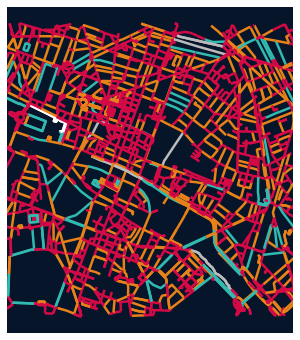

In [57]:
#Valencia: 39.466667, -0.375
#Barcelona: 41.390205, 2.154007
#Paris: 48.856613, 2.352222

# Center of map
latitude = 48.856613  
longitude = 2.352222

G = ox.graph_from_point((latitude, longitude), dist=1500, network_type='none', custom_filter = tags)
# gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
# gdf_edges

u = []
v = []
key = []
data = []
for uu, vv, kkey, ddata in G.edges(keys=True, data=True):
    u.append(uu)
    v.append(vv)
    key.append(kkey)
    data.append(ddata)   

    # List to store colors
roadColors = []

# The length is in meters
for item in data:
    if "length" in item.keys():
        
        if item["length"] <= 100:
            color = "#d40a47"
            
        elif item["length"] > 100 and item["length"] <= 200:
            color = "#e78119"
            
        elif item["length"] > 200 and item["length"] <= 400:
            color = "#30bab0"
            
        elif item["length"] > 400 and item["length"] <= 800:
            color = "#bbbbbb"
            
        else:
            color = "w"
             
    roadColors.append(color)
    
# List to store linewidths
roadWidths = []

for item in data:
    if "footway" in item["highway"]:
        linewidth = 1

    else:
        linewidth = 2.5
        
    roadWidths.append(linewidth)

# Bbox sides
north = latitude + 0.015
south = latitude - 0.015
east = longitude + 0.02
west = longitude - 0.02

# Make Map
fig, ax = ox.plot_graph(G, node_size=0, bbox = (north, south, east, west), figsize=(6,6),  
                        dpi = 300,  bgcolor = "#061529",
                        save = False, edge_color=roadColors,
                        edge_linewidth=roadWidths, edge_alpha=1,show=False, close=False)

# Text and marker size
markersize = 16
fontsize = 16

# # Add legend
# legend_elements = [Line2D([0], [0], marker='s', color="#061529", label= 'Length < 100 m',
#                           markerfacecolor="#d40a47", markersize=markersize),
                          
#                   Line2D([0], [0], marker='s', color="#061529", label= 'Length between 100-200 m',
#                          markerfacecolor="#e78119", markersize=markersize),
                  
#                   Line2D([0], [0], marker='s', color="#061529", label= 'Length between 200-400 m',
#                          markerfacecolor="#30bab0", markersize=markersize),
                  
#                   Line2D([0], [0], marker='s', color="#061529", label= 'Length between 400-800 m',
#                          markerfacecolor="#bbbbbb", markersize=markersize),
                  
#                   Line2D([0], [0], marker='s', color="#061529", label= 'Length > 800 m',
#                   markerfacecolor="w", markersize=markersize)]    
                      
# l = ax.legend(handles=legend_elements, bbox_to_anchor=(0.0, 0.0), frameon=True, ncol=1,
#               facecolor = '#061529', framealpha = 0.9,
#               loc='lower left',  fontsize = fontsize, prop={'family':"Georgia", 'size':fontsize}, title="Street length")  
  
# # Legend font color
# for text in l.get_texts():
#     text.set_color("w")

# ax.add_artist(l)

plt.show()

### 3.3 Street bearing

<ipython-input-45-b7aea2f0b2ed>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111, projection='polar')


Text(0.5, 1.1, 'Valencia_street network edge bearings')

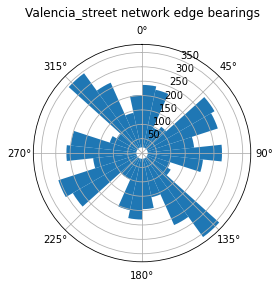

In [45]:
# Valencia: 39.466667, -0.375
# Paris: 48.856613, 2.352222
# Barcelona: 41.390205, 2.154007

distance = 1500
tags = '["highway"~"primary|secondary|tertiary|unclassified|residential|pedestrian|steps|path|service"]'

G = ox.graph_from_point((39.466667, -0.375), dist=distance, network_type='none', custom_filter = tags)
G = ox.add_edge_bearings(G)

bearings = pd.Series([data['bearing'] for u, v, k, data in G.edges(keys=True, data=True)])
ax = bearings.hist(bins=30, zorder=2, alpha=0.8)
xlim = ax.set_xlim(0, 360)
ax.set_title('bearning')

n = 30
bins = [ang * 360 / n for ang in range(0, n + 1)]
count, division = np.histogram(bearings, bins=bins, range=(bearings.min(), bearings.max()))
division = division[0:-1]
width =  2 * np.pi/n
ax = plt.subplot(111, projection='polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction('clockwise')
bars = ax.bar(division * np.pi/180 - width * 0.5 , count, width=width, bottom=20.0)
ax.set_title(cities_3[0]+"_"+'street network edge bearings', y=1.1)
# ax.set_title(cities[0]+"_"+'street network edge bearings', y=1.1)

# 4. Clustering multiple networks (by urban order)

### 4.1Select indicators for street orientation

In [58]:
cities_43 = ["L'Hospitalet de Llobregat", "Paris", "Athens", "Thessaloniki", "Barcelona",
          "Senglea","Lyon","Cadiz","Bilbao","Bucharest",
          "Naples","Milan","Brussels","Porto","Turin",
          "Copenhagen","A Coruña","Lisbon","The Hague","Valencia",
          "Madrid","Amsterdam","Bordeaux","Seville","Stockholm",
          "Montpellier","Dublin","Nice","Munich","Vienna",
          "Palermo","Ottobrunn","Malmö","Berlin","Toulouse",
          "Saint-Nicolas","Warsaw","Rome","Budapest",
          "Gröbenzell","Stuttgart","Herne","Frankfurt am Main"]

points_43 = [(41.359722, 2.1),(48.856613, 2.352222),(37.983972, 23.727806),(40.65, 22.9),(41.390205, 2.154007),
          (35.887778, 14.516944),(45.76, 4.84),(36.535, -6.2975),(43.256944, -2.923611),(44.4325, 26.103889),
          (40.833333, 14.25),(45.466944, 9.19),(50.85, 4.35),(41.162142, -8.621953),(45.079167, 7.676111),
          (55.676111, 12.568333),(43.365, -8.41),(38.725267, -9.150019),(52.083333, 4.316667),(39.466667, -0.375),
          (40.383333, -3.716667),(52.366667, 4.9),(44.84, -0.58),(37.39, -5.99),(59.329444, 18.068611),
          (43.6119, 3.8772),(53.35, -6.266667),(43.7034, 7.2663),(48.133333, 11.566667),(48.2, 16.366667),
          (38.116667, 13.366667),(48.066667, 11.666667),(55.605833, 13.035833),(52.52, 13.405),(43.6045, 1.444),
          (43.6045, 1.444),(52.233333, 21.016667),(41.883333, 12.5),(47.4925, 19.051389),
          (48.2, 11.366667),(48.783333, 9.183333),(51.55, 7.216667),(50.116667, 8.683333)]
density = (21364, 20909, 19135, 16840, 15991, 13920, 10460, 9700, 8688, 8449, 8183, 7519, 7465, 6900, 6786, 6711, 6510, 6446,
           6445, 5799, 5390, 5135, 5081, 5022, 5012, 4840, 4811, 4782, 4736, 4556, 4164, 4119, 4108, 4090, 4054, 3518, 3421, 
           3389, 3355, 3337, 3139, 3062, 3041, 3033)
distance = 500
tags = '["highway"~"primary|secondary|tertiary|unclassified|residential|pedestrian|steps|path|service"]'

df_all = pd.DataFrame(columns=["bc", "clustering_coefficient", "street_length_avg", "circuity_avg", "node_degree_avg"])  #Create a Dataframe with column names: ""num_nodes", "num_edges", "points"
for i in range(0,len(points_43)):
    G = ox.graph_from_point(points_43[i], dist=500, network_type='none', custom_filter = tags)
    #===============2. Statistics
    stats = ox.basic_stats(G, area=None, clean_intersects=False, tolerance=15, circuity_dist='gc')
    extended_stats = ox.extended_stats(G, connectivity=True, anc=False, ecc=False, bc=True, cc=True)
    #==========5.Street orientation=======================
    G = ox.add_edge_bearings(G)
    bearings = pd.Series([data['bearing'] for u, v, k, data in G.edges(keys=True, data=True)])
    
    #Calculate entropy
    from scipy.stats import entropy
    pd_series = pd.Series(bearings)
    counts = pd_series.value_counts()
    entropy_count = entropy(counts)
    
    #=============DataFrame========
    #         df_all["num_nodes"] = df_all["num_nodes"].astype(object)
    #         df_all["num_edges"] = df_all["num_edges"].astype(object)
    df_all.loc[cities_43[i], "bc"] = np.array(extended_stats['betweenness_centrality_avg']) #垂直增加city cases
    df_all.loc[cities_43[i], "clustering_coefficient"] = np.array(extended_stats['clustering_coefficient_avg'])
    df_all.loc[cities_43[i], "street_length_avg"] = np.array(stats['street_length_avg'])
    df_all.loc[cities_43[i], "circuity_avg"] = np.array(stats['circuity_avg'])
    df_all.loc[cities_43[i], "node_degree_avg"] = np.array(stats['k_avg'])
    df_all.loc[cities_43[i], "entropy of street bearing"] = np.array(entropy_count)
    
df_all

,bc,clustering_coefficient,street_length_avg,circuity_avg,node_degree_avg,entropy of street bearing
L'Hospitalet de Llobregat,0.0642656697119321,0.0521415270018622,66.75471653543306,1.0253448087314887,3.541899441340782,5.614009
Paris,0.042484991321431284,0.011024643320363164,56.0737784090909,1.0566877886097412,3.782101167315175,5.794579
Athens,0.03996505152679488,0.041216216216216225,55.102553846153796,1.014204508356736,3.810810810810811,5.248760
Thessaloniki,0.18663101604278073,0.02857142857142857,30.812521739130442,1.0519426320603802,4.171428571428572,4.176517
Barcelona,0.05613574724384489,0.009363295880149811,105.73075384615382,1.0562808233784817,3.101123595505618,4.355768
Senglea,0.06325636018517254,0.030534351145038167,47.14543414634144,1.090063928465308,5.374045801526718,5.564826
Lyon,0.041926176081350075,0.03294573643410853,57.61387222222224,1.0391134803565456,3.3488372093023258,5.600814
Cadiz,0.044853599385869136,0.03637901861252114,48.60822021660648,1.0609337157722523,4.456852791878172,5.780058
Bilbao,0.04415334044849007,0.058461538461538474,50.764950909090935,1.3000258307355124,6.024615384615385,6.440251
Bucharest,0.03497626983883787,0.10978179082016566,43.74653304597703,1.1271428744426677,5.544018058690745,6.761567


### 4.2 Clustering analysis (hierarchical clustering)

[0 0 0 2 1 1 0 1 1 1 0 1 2 0 0 0 1 0 0 0 0 0 0 1 1 2 1 0 1 0 1 2 0 0 0 0 0
 0 0 1 1 0 1]


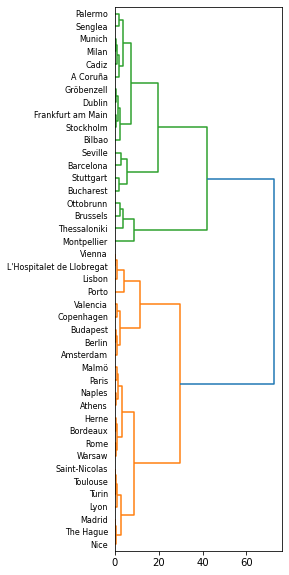

In [575]:
#Dendrogram
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
# create dendrogram
fig, axes = plt.subplots(1, 1, figsize=(3, 10))
dendrogram = sch.dendrogram(sch.linkage(df_all, method='ward'), labels= cities, leaf_rotation=0, orientation="right") #, color_threshold=240, above_threshold_color='grey')
# create clusters
hc = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')

# save clusters for chart
y_hc = hc.fit_predict(df_all)
print(hc.labels_) 

### 4.2 t-SNE

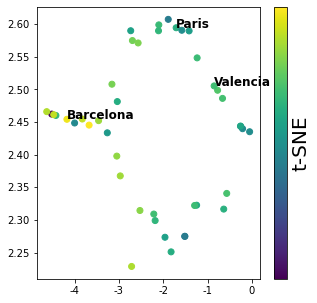

In [601]:
#t-SNE

cities_label_43 = ["", "Paris", "", "", "Barcelona",
          "","","","","",
          "","","","","",
          "","","","","Valencia",
          "","","","","",
          "","","","","",
          "","","","","",
          "","","","",
          "","","",""]
df_all_test123 = pd.DataFrame(df_all['entropy of street bearing'] )
df_all.shape
m = TSNE(learning_rate = 50)
tsne_features =m.fit_transform(df_all)
df_all['x'] = tsne_features[:,0]
df_all['y'] = tsne_features[:,1]
#===Visualize data 1================================================================
fig = plt.figure(figsize=(5,5))
inset = fig.add_subplot(111)
colors = df_all['entropy of street bearing']
axis = plt.scatter(x='x', y='y',data=df_all, c=colors)

#####Label data points
for i in range(0, len(cities)):
    plt.text(tsne_features[i, 0], tsne_features[i, 1], str(cities_label_43[i]), color='black', 
             fontdict={'weight': 'bold', 'size': 12})
####Legend
cb = fig.colorbar(axis,ticks=[0,0.5,1])
cb.set_label('t-SNE', fontsize = 20)
cb.ax.tick_params(labelsize=30)
plt.show()

# 5. POIs_Accessibility to POIs

# 6. Transit network (GTIS)